# Рекуррентные сети 2

## Задание 
Сгенерировать последовательности, которые бы состояли из цифр (от 0 до 9) и задавались следующим образом:  
x - последовательность цифр  
y1 = x1, y(i) = x(i) + x(1). Если y(i) >= 10, то y(i) = y(i) - 10

### Задача:
научить модель предсказывать y(i) по x(i)  
пробовать RNN, LSTM, GRU

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Функция для генерации одной пары последовательностей

In [2]:
def generate_sequence(seq_length):
    """
    Генерирует пару последовательностей (x, y) согласно заданному правилу.
    :param seq_length: Длина последовательности
    :return: Кортеж из двух numpy массивов: (x, y)
    """
    x = np.random.randint(0, 10, size=seq_length)  # Входная последовательность x
    y = np.zeros(seq_length, dtype=int)  # Инициализируем y нулями
    y[0] = x[0]  # y[0] = x[0]
    for i in range(1, seq_length):
        y[i] = x[i] + x[0]
        if y[i] >= 10:
            y[i] -= 10  # Если y[i] >= 10, вычитаем 10
    return x, y

### Генерация датасета

In [3]:
def generate_dataset(num_samples, seq_length):
    """
    Генерирует датасет из заданного числа образцов.
    :param num_samples: Количество образцов в датасете
    :param seq_length: Длина каждой последовательности
    :return: Список пар (x, y)
    """
    dataset = []
    for _ in range(num_samples):
        x, y = generate_sequence(seq_length)
        dataset.append((x, y))
    return dataset

In [4]:
num_samples = 10000  # Количество образцов
seq_length = 10      # Длина каждой последовательности
dataset = generate_dataset(num_samples, seq_length)

### Создание класса датасета

In [5]:
class SequenceDataset(Dataset):
    def __init__(self, dataset):
        """
        Инициализирует датасет для использования с DataLoader.
        :param dataset: Список пар (x, y)
        """
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        # Преобразуем в тензоры
        x_tensor = torch.tensor(x, dtype=torch.long)
        y_tensor = torch.tensor(y, dtype=torch.long)
        return x_tensor, y_tensor

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [7]:
batch_size = 64

train_dataset = SequenceDataset(train_data)
test_dataset = SequenceDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
input_size = 10    # Входные цифры от 0 до 9
hidden_size = 32   # Размер скрытого состояния
output_size = 10   # Выходные цифры от 0 до 9
num_layers = 1     # Количество слоев в RNN

### Базовый класс модели

In [9]:
class BaseModel(nn.Module):
    def __init__(self, rnn_type):
        super(BaseModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers)
        else:
            raise ValueError("Invalid RNN type")
        self.fc = nn.Linear(hidden_size, output_size)
        self.rnn_type = rnn_type
        
    def forward(self, x):
        """
        Прямой проход модели.
        :param x: Входная последовательность (batch_size, seq_length)
        :return: Выходная последовательность (batch_size, seq_length, output_size)
        """
        embedded = self.embedding(x)  # Преобразуем входные цифры в эмбеддинги
        embedded = embedded.permute(1, 0, 2)  # (seq_length, batch_size, hidden_size)
        
        if self.rnn_type == 'LSTM':
            output, (hn, cn) = self.rnn(embedded)
        else:
            output, hn = self.rnn(embedded)
        
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, hidden_size)
        output = self.fc(output)  # Применяем полносвязный слой к каждому выходу
        return output

In [10]:
model_rnn = BaseModel('RNN')
model_lstm = BaseModel('LSTM')
model_gru = BaseModel('GRU')

### Определение функции обучения

In [11]:
def train_model(model, train_loader, test_loader, num_epochs=5):
    """
    Обучает заданную модель.
    :param model: Экземпляр модели для обучения
    :param train_loader: DataLoader для обучающей выборки
    :param test_loader: DataLoader для тестовой выборки
    :param num_epochs: Количество эпох обучения
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            outputs = outputs.view(-1, output_size)
            targets = y_batch.view(-1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        accuracy = evaluate_model(model, test_loader)
        accuracy_history.append(accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
        
    return loss_history, accuracy_history

### Определение функции оценки модели

In [12]:
def evaluate_model(model, test_loader):
    """
    Оценивает модель на тестовой выборке.
    :param model: Экземпляр модели
    :param test_loader: DataLoader для тестовой выборки
    """
    model.eval()
    total_correct = 0
    total_elements = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            predictions = torch.argmax(outputs, dim=2)
            total_correct += (predictions == y_batch).sum().item()
            total_elements += y_batch.numel()
    accuracy = total_correct / total_elements * 100
    return accuracy

### Обучение моделей

In [13]:
# Обучение Simple RNN
print("Training Simple RNN Model:")
loss_rnn, acc_rnn = train_model(model_rnn, train_loader, test_loader, num_epochs=10)

Training Simple RNN Model:
Epoch 1/10, Loss: 2.2773, Accuracy: 18.55%
Epoch 2/10, Loss: 2.2531, Accuracy: 18.55%
Epoch 3/10, Loss: 2.2150, Accuracy: 19.31%
Epoch 4/10, Loss: 2.0620, Accuracy: 24.95%
Epoch 5/10, Loss: 1.8996, Accuracy: 27.52%
Epoch 6/10, Loss: 1.7615, Accuracy: 31.33%
Epoch 7/10, Loss: 1.6529, Accuracy: 37.94%
Epoch 8/10, Loss: 1.5592, Accuracy: 40.59%
Epoch 9/10, Loss: 1.4770, Accuracy: 44.40%
Epoch 10/10, Loss: 1.3993, Accuracy: 47.34%


In [14]:
# Обучение LSTM
print("\nTraining LSTM Model:")
loss_lstm, acc_lstm = train_model(model_lstm, train_loader, test_loader, num_epochs=10)


Training LSTM Model:
Epoch 1/10, Loss: 2.2758, Accuracy: 18.93%
Epoch 2/10, Loss: 2.1323, Accuracy: 31.96%
Epoch 3/10, Loss: 1.5795, Accuracy: 63.43%
Epoch 4/10, Loss: 0.9190, Accuracy: 90.92%
Epoch 5/10, Loss: 0.5264, Accuracy: 99.17%
Epoch 6/10, Loss: 0.3166, Accuracy: 99.97%
Epoch 7/10, Loss: 0.2002, Accuracy: 100.00%
Epoch 8/10, Loss: 0.1370, Accuracy: 100.00%
Epoch 9/10, Loss: 0.0996, Accuracy: 100.00%
Epoch 10/10, Loss: 0.0756, Accuracy: 100.00%


In [15]:
# Обучение GRU
print("\nTraining GRU Model:")
loss_gru, acc_gru = train_model(model_gru, train_loader, test_loader, num_epochs=10)


Training GRU Model:
Epoch 1/10, Loss: 2.2755, Accuracy: 18.81%
Epoch 2/10, Loss: 2.2089, Accuracy: 21.48%
Epoch 3/10, Loss: 2.0406, Accuracy: 32.02%
Epoch 4/10, Loss: 1.6869, Accuracy: 50.37%
Epoch 5/10, Loss: 1.2729, Accuracy: 73.67%
Epoch 6/10, Loss: 0.8710, Accuracy: 90.70%
Epoch 7/10, Loss: 0.5739, Accuracy: 97.01%
Epoch 8/10, Loss: 0.3820, Accuracy: 99.36%
Epoch 9/10, Loss: 0.2622, Accuracy: 99.74%
Epoch 10/10, Loss: 0.1916, Accuracy: 99.89%


### Построение графиков для сравнения моделей

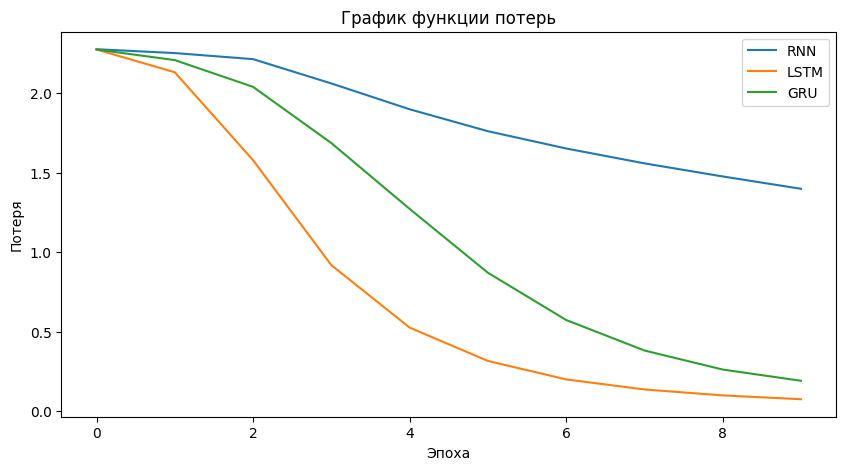

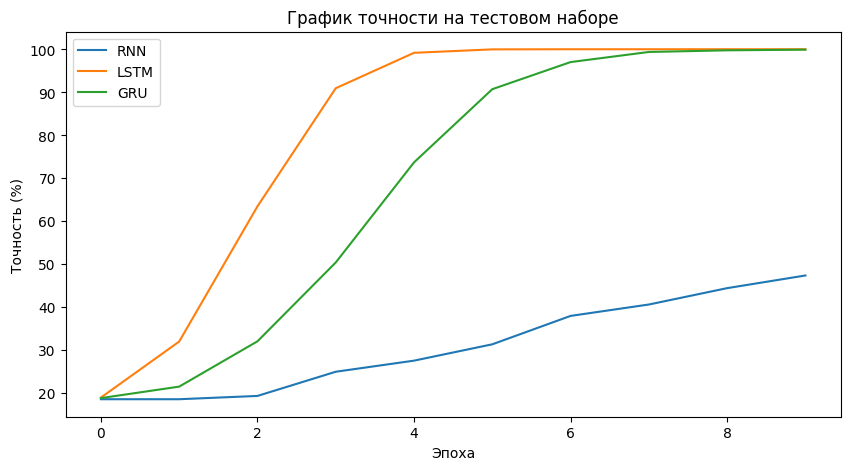

In [16]:
import matplotlib.pyplot as plt

# График функции потерь
plt.figure(figsize=(10,5))
plt.plot(loss_rnn, label='RNN')
plt.plot(loss_lstm, label='LSTM')
plt.plot(loss_gru, label='GRU')
plt.title('График функции потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.show()

# График точности
plt.figure(figsize=(10,5))
plt.plot(acc_rnn, label='RNN')
plt.plot(acc_lstm, label='LSTM')
plt.plot(acc_gru, label='GRU')
plt.title('График точности на тестовом наборе')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()
plt.show()

### Проверка моделей на отдельных примерах

In [17]:
def test_example(model, x_seq):
    model.eval()
    x_tensor = torch.tensor(x_seq, dtype=torch.long).unsqueeze(0)
    with torch.no_grad():
        outputs = model(x_tensor)
        predictions = torch.argmax(outputs, dim=2)
    return predictions.squeeze().numpy()

# Выбор примера из тестового набора
x_example, y_true = test_data[0]
y_pred_rnn = test_example(model_rnn, x_example)
y_pred_lstm = test_example(model_lstm, x_example)
y_pred_gru = test_example(model_gru, x_example)

print(f"Входная последовательность x: {x_example}")
print(f"Истинная последовательность y: {y_true}")
print(f"Предсказание RNN:  {y_pred_rnn}")
print(f"Предсказание LSTM: {y_pred_lstm}")
print(f"Предсказание GRU:  {y_pred_gru}")

Входная последовательность x: [1 7 2 2 0 3 9 9 1 0]
Истинная последовательность y: [1 8 3 3 1 4 0 0 2 1]
Предсказание RNN:  [1 2 8 8 7 6 7 7 2 6]
Предсказание LSTM: [1 8 3 3 1 4 0 0 2 1]
Предсказание GRU:  [1 8 3 3 1 4 0 0 2 1]


## Шаги, выполненные в работе
1) **Генерация данных:**

    - Создал функцию для генерации последовательностей **x** и соответствующих им **y** по заданному правилу.
    - Сгенерировал датасет из 10,000 образцов с длиной последовательности 10.
      
2) **Подготовка данных:**

    - Разделил данные на обучающую и тестовую выборки в соотношении 80/20.
    - Создал классы **Dataset** и **DataLoader** для удобной подачи данных в модели.
      
3) **Определение моделей:**

    - Реализовал общий класс **BaseModel**, который в зависимости от параметра **rnn_type** использует либо **RNN**, либо **LSTM**, либо **GRU**.
    - Каждая модель состоит из следующих слоев:
        a) **Embedding** для преобразования входных цифр в векторные представления.
        b) Рекуррентный слой (**RNN**, **LSTM** или **GRU**).
        c) Полносвязный слой **Linear** для получения выходных предсказаний.
      
4) **Обучение моделей:**

    - Обучил каждую модель на протяжении 10 эпох.
    - Использовал функцию потерь **CrossEntropyLoss** и оптимизатор **Adam**.
    - Сохранял историю потерь и точности для последующего анализа.
      
5) **Оценка моделей:**

    - После каждой эпохи вычислял точность на тестовой выборке.
    - Построил графики функции потерь и точности для каждой модели.
    - Провел тестирование на отдельном примере из тестового набора данных.

## Анализ результатов
1) **Simple RNN:**

    - Обучение шло медленно, и за 10 эпох модель достигла точности ~47%.
    - На тестовом примере модель выдала неверные предсказания, что указывает на проблемы с запоминанием длинных зависимостей.
      
2) **LSTM и GRU:**

    - Обе модели показали быстрый рост точности уже на первых эпохах.
    - К 5-й эпохе точность превысила 90%, а к 10-й — приблизилась к 100%.
    - На тестовом примере предсказания полностью совпали с истинными значениями.

## Выводы

- **LSTM** и **GRU** значительно превосходят **Simple RNN** в данной задаче. Это объясняется тем, что они эффективно справляются с запоминанием долгосрочных зависимостей благодаря своим архитектурам, использующим механизмы забывания и запоминания информации.
- **Simple RNN** страдает от проблемы затухающих градиентов, что препятствует эффективному обучению на более длинных последовательностях.
- **Графики функции потерь и точности** подтверждают, что **LSTM** и **GRU** сходятся быстрее и достигают более высоких результатов по сравнению с **Simple RNN**.

## Заключение
В результате работы я убедился в преимуществах использования более сложных архитектур рекуррентных нейронных сетей, таких как **LSTM** и **GRU**, для задач, требующих запоминания долгосрочных зависимостей. Эти модели продемонстрировали высокую точность и стабильность обучения. В дальнейшем планирую экспериментировать с гиперпараметрами и дополнительными методами регуляризации, чтобы еще больше улучшить результаты и понять возможности моделей в различных условиях.